### Resources

- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- https://arxiv.org/pdf/1312.5602
- https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained

In [1]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import pickle
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
    EpisodicLifeEnv,
    MaxAndSkipEnv,
)

gym.register_envs(ale_py)

Helper functions

In [2]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [3]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [12]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env)
    env = FrameStack(env, num_stack=4)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    return env

In [5]:
env = make_env('PongNoFrameskip-v4')

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


Before processing state

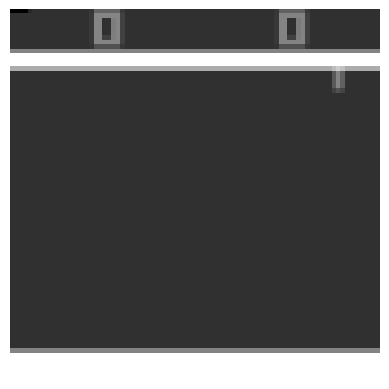

In [8]:
obs, info = env.reset()
display_frame(obs[-1], gray=True)

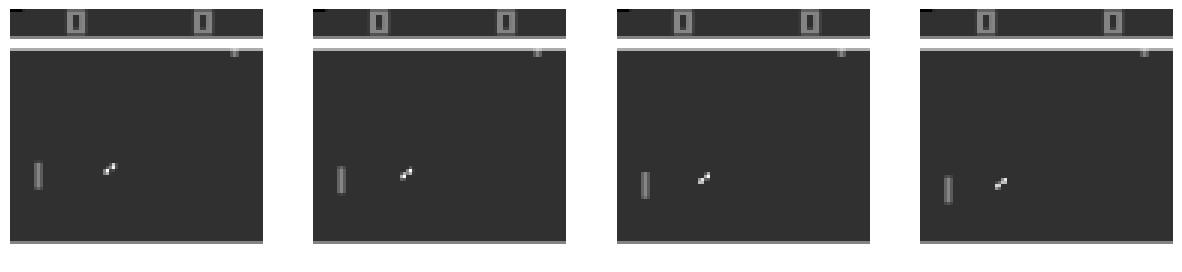

In [9]:
obs, info = env.reset()
display_multiple_frames(obs)

### Experience Replay

In [111]:
class ReplayBuffer:

    def __init__(self, capacity=10000) -> None:
        self._buffer_obs = deque(maxlen=capacity)
        self._buffer_acts = deque(maxlen=capacity)
        self._buffer_rs = deque(maxlen=capacity)
        self._buffer_obs_ps = deque(maxlen=capacity)
        self._buffer_dones = deque(maxlen=capacity)

        self._buffers = [self._buffer_obs, self._buffer_acts, self._buffer_rs, self._buffer_obs_ps, self._buffer_dones]

    def store(self, experience: tuple) -> None:
        for i, thing in enumerate(experience):
            self._buffers[i].append(thing)

    def sample(self, batch_size):
        indices = np.random.randint(0, high=len(self), size=(batch_size))

        observations, actions, rewards, obs_primes, dones = self.buffers
        return (
            np.take(observations, indices, axis=0),
            np.take(actions, indices, axis=0).reshape(-1, 1),
            np.take(rewards, indices, axis=0).reshape(-1, 1),
            np.take(obs_primes, indices, axis=0),
            np.take(dones, indices, axis=0).reshape(-1, 1),
        )

    def __len__(self):
        return len(self._buffer_obs)

    def __getitem__(self, index):
        return tuple([buffer[index] for buffer in self._buffers])

    def __setitem__(self, index, value: tuple):
        for i, buffer in enumerate(self._buffers):
            buffer[index] = value[i]

    def shuffle(self):
        np.random.shuffle(self.buffer)

    @property
    def shape(self):
        if len(self._buffer_obs) > 0:
            shape = (len(self._buffer_obs), 5)
            return shape
        else:
            return (0,)

    @property
    def buffers(self):
      npbuffers = [np.array(buffer) for buffer in self._buffers]
      return tuple(npbuffers)

In [121]:
NUM_EPS = 100
buffer_pong = ReplayBuffer()

for episode in range(NUM_EPS):
    done = False
    observation, _ = env.reset()
    step = 1

    next_state = [observation]

    while not done:
        action = env.action_space.sample()

        observation_prime, reward, terminated, truncated, _ = env.step(action)
        buffer_pong.store((observation[:, :, :, 0], action, reward, observation_prime[:, :, :, 0], terminated or truncated))
        observation = observation_prime

        done = terminated or truncated

print(len(buffer_pong))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10000


(4, 84, 84)


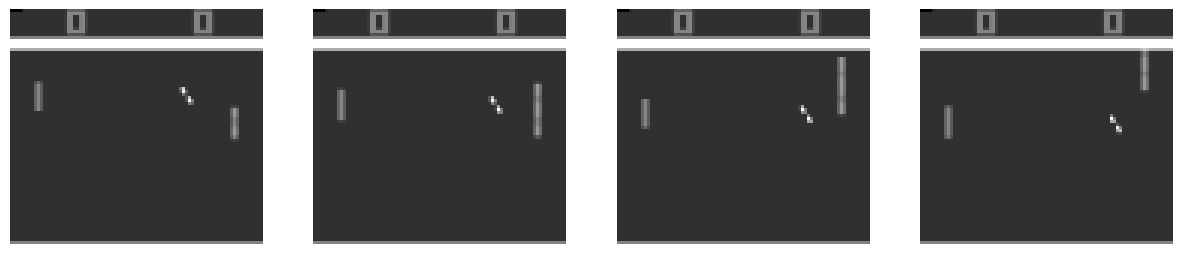

In [83]:
frame = buffer_pong[10][3]
print(frame.shape)
display_multiple_frames(frame)

In [ ]:
with open('replays/replay1.pkl', 'wb') as f:
    pickle.dump(buffer_pong, f)

In [7]:
class DQN(nn.Module):

    def __init__(
        self,
        env,
        in_channels = 4,
        num_actions = 6,
        hidden_filters = [16, 32],
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.env = env

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[1] * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

        self.apply(self._init)

    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x / 255.0)

    def epsilon_greedy(self, state, dim=1):
        q_values = self(state)
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = torch.argmax(q_values, dim=dim)

        return np.int64(action)

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)


Training procedure

In [122]:
EPISODES = 20
LR = 2.5e-4
BATCH_SIZE = 32
C = 10000
GAMMA = 0.99
FINAL_ANNEAL = 1000000

q_network = DQN(env, decay_steps=FINAL_ANNEAL)
target_network = DQN(env, decay_steps=FINAL_ANNEAL)
target_network.load_state_dict(q_network.state_dict())

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(q_network.parameters(), lr=LR)

step = 0
episode = 0
for episode in range(EPISODES):

    obs, _ = env.reset()
    done = False
    episode += 1

    while not done:
        batched_obs = obs[np.newaxis, :, :, :, 0]
        action = q_network.epsilon_greedy(torch.tensor(batched_obs).float()).item()
        obs_prime, reward, terminated, trunctated, _ = env.step(action)

        buffer_pong.store((obs[:, :, :, 0], action, reward, obs_prime[:, :, :, 0], terminated or truncated))

        observations, actions, rewards, observation_primes, dones = buffer_pong.sample(BATCH_SIZE)
        with torch.no_grad():
            q_values_minus = target_network(torch.tensor(observation_primes).float())
            boostrapped_values = torch.amax(q_values_minus, dim=1, keepdim=True)

        terminated_primes = torch.tensor(dones).bool()
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards).float()
        y_trues = torch.empty((BATCH_SIZE, 1))

        y_trues = torch.where(terminated_primes, rewards, rewards + GAMMA * boostrapped_values)
        y_preds = q_network(torch.tensor(observations).float())

        loss = loss_func(y_preds.gather(1, actions), y_trues)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step += 1
        q_network.epsilon_decay(step)
        target_network.epsilon_decay(step)

        done = terminated or truncated
        obs = obs_prime
        if step % C == 0:
            target_network.load_state_dict(q_network.state_dict())
    print(f'Episode: {episode}, Last loss: {loss}')

Episode: 1, Last loss: 0.08380358666181564
Episode: 2, Last loss: 0.054279036819934845
Episode: 3, Last loss: 0.06152406334877014
Episode: 4, Last loss: 0.0072293211705982685
Episode: 5, Last loss: 0.009798569604754448
Episode: 6, Last loss: 0.006577817723155022
Episode: 7, Last loss: 0.07612144947052002
Episode: 8, Last loss: 0.010602391324937344
Episode: 9, Last loss: 0.025510592386126518
Episode: 10, Last loss: 0.011926836334168911
Episode: 11, Last loss: 0.0074654389172792435
Episode: 12, Last loss: 0.008179208263754845
Episode: 13, Last loss: 0.015239791944622993
Episode: 14, Last loss: 0.025628594681620598
Episode: 15, Last loss: 0.023219378665089607
Episode: 16, Last loss: 0.002635975368320942
Episode: 17, Last loss: 0.02234048955142498
Episode: 18, Last loss: 0.0026851759757846594
Episode: 19, Last loss: 0.017188379541039467
Episode: 20, Last loss: 0.007014555390924215


In [123]:
torch.save(q_network.state_dict(), 'q_net1.pt')

In [13]:
env2 = make_env('PongNoFrameskip-v4', render='human')

q_network_trained = DQN(env)
q_network_trained.load_state_dict(torch.load('q_net1.pt', weights_only=True))
q_network_trained.eval()

DQN(
  (layers): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2592, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [ ]:
done = False
total_reward = 0

obs, _ = env2.reset()
while not done:
    batched_obs = obs[np.newaxis, :, :, :, 0]
    with torch.no_grad():
        logits = q_network_trained(torch.tensor(batched_obs).float())
        action = torch.argmax(logits, dim=1).item()
        
    next_observation, reward, terminated, truncated, _ = env2.step(action)
    total_reward += reward
    obs = next_observation
    
    done = terminated or truncated
    
env2.close()
print(f'Total reward achieved: {total_reward}')